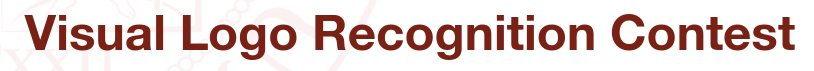

VISION AND COGNITIVE SYSTEMS A.Y. 2022/2023

The aim of the contest is to retrieve the most similar images representing logos of famous companies from a database set containing 110 images. We will consider 4 query images and use the SIFT algorithm. Model performance will be evaluated using average precision (AP) and mean average precision (mAP) metrics.
You can modify the baseline (parameters, feature matching technique, ...) and then submit your results.

- [Submit results](https://forms.gle/mNjZNVjuDuDkffBB6)
- [Visualize Submissions](https://bit.ly/3EZbYSn)

In [3]:
%%capture
# Update OpenCV package
!pip install -U opencv-python
!pip install opencv-contrib-python

In [5]:
# Upload the zip folders (query.zip and database.zip)
%%capture
!unzip query.zip
!unzip database.zip

UsageError: Line magic function `%%capture` not found.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# List of query/database images
query_images = []
db_images = []
logo_names = []

# Resize images
img_size = (400, 400)

# Read query images
# Order by name
query_dir = sorted(os.listdir('query/'))
for idx, img_name in enumerate(query_dir):
  # Read image
  img = cv2.imread(os.path.join('query/', img_name))
  # Resize image
  img = cv2.resize(img, dsize=img_size)
  # Save image
  query_images.append(img)
  # Save logo names (remove "_logo.txt" and capitalize)
  logo_names.append(os.path.splitext(img_name)[0][:-5].capitalize())
  #print("Image '" + img_name + "' loaded.")
print("Query images loaded!")

# Read db images
# Order by number
db_dir = sorted(os.listdir('database/'), key=lambda x: int(x.split('.')[0]))
for idx, img_name in enumerate(db_dir):
  # Read image
  img = cv2.imread(os.path.join('database/', img_name))
  # Resize image
  img = cv2.resize(img, dsize=img_size)
  # Save image
  db_images.append(img)
  #print("Image '" + img_name + "' loaded.")
print("Database images loaded!")

In [ ]:
# Plot query images
fig = plt.figure(figsize=(12,12))
for i in range(len(query_images)):
  _ = plt.subplot(1, len(query_images), i+1), plt.title("Query image n. " + str(i))
  plt.imshow(cv2.cvtColor(query_images[i], cv2.COLOR_BGR2RGB)), plt.axis('off')

# Plot database images
fig = plt.figure(figsize=(12, 80))
for i in range(len(db_images)):
  _ = plt.subplot(int(len(db_images)/5), 5, i+1), plt.title("DB image n. " + str(i))
  plt.imshow(cv2.cvtColor(db_images[i], cv2.COLOR_BGR2RGB)), plt.axis('off')

In [ ]:
# # Ground-truth arrays per logo
coca_cola_GT = np.zeros(len(db_images))
marlboro_GT = np.zeros(len(db_images))
starbucks_GT = np.zeros(len(db_images))
heineken_GT = np.zeros(len(db_images))

coca_cola_GT[18:25] = 1
marlboro_GT[55:61] = 1
marlboro_GT[100:] = 1
starbucks_GT[70:100] = 1
heineken_GT[25:55] = 1

# Matrix containing ground-truth values for each query image
GT_matrix = np.vstack([coca_cola_GT, heineken_GT, marlboro_GT, starbucks_GT])
print(f"GT matrix shape: {GT_matrix.shape}")

n_coca_cola = int(coca_cola_GT.sum())
n_heineken = int(heineken_GT.sum())
n_marlboro = int(marlboro_GT.sum())
n_starbucks = int(starbucks_GT.sum())
n_others = len(db_images) - (n_coca_cola + n_heineken + n_marlboro + n_starbucks)
print(f"Number of database images (coca_cola): {n_coca_cola}")
print(f"Number of database images (heineken): {n_heineken}")
print(f"Number of database images (marlboro): {n_marlboro}")
print(f"Number of database images (starbucks): {n_starbucks}")
print(f"Number of database images (others): {n_others}")
# print(GT_matrix)

SIFT algorithm (default parameters)

In [ ]:
# Define SIFT detector object
detector = cv2.SIFT_create()

# Detect and compute interest points and their descriptors
query_kps = []
query_des = []
db_kps = []
db_des = []

for i in range(len(query_images)):
  kp, des = detector.detectAndCompute(query_images[i], None)
  query_kps.append(kp)
  query_des.append(des)

for i in range(len(db_images)):
  kp, des = detector.detectAndCompute(db_images[i], None)
  db_kps.append(kp)
  db_des.append(des)

Ratio test

In [ ]:
# Brute-force matcher
bf = cv2.BFMatcher_create(cv2.NORM_L2)

# Matrix containing the number of matches per logo
num_matches = np.zeros((len(query_images), len(db_images)))

# Filter matches using the Lowe's ratio test
ratio_thresh = 0.66

# Save  matches for each descriptor of query images
logo_matches = [] # List of lists

# For each query image
for q in range(len(query_images)):
  q_matches = []
  # For each database image
  for db in range(len(db_images)):
    matches = bf.knnMatch(query_des[q], db_des[db], k=2)
    # Apply ratio test
    n_matches = 0
    sel_matches = []
    for m,n in matches:
      if m.distance < ratio_thresh * n.distance:
        n_matches += 1
        sel_matches.append(m)
    # Save number of matches
    num_matches[q, db] = n_matches
    # Save matches
    q_matches.append(sel_matches)
  logo_matches.append(q_matches)

for idx, logo in enumerate(logo_names):
  print("Number of matches (" + logo + "):")
  print(num_matches[idx])

In [ ]:
# Draw some matches
_  = plt.figure(figsize=(15, 8))
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), flags=0)
plt_list = [25, 18, 71, 108]
for idx, n in enumerate(plt_list):
  img_matches = cv2.drawMatches(query_images[3], query_kps[3], db_images[n], db_kps[n], logo_matches[3][n], None, **draw_params)
  _ = plt.subplot(2, 2, idx+1), plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))

# **Performance Evaluation**

The performance of the model will be evaluated in terms of precision, recall and average precision.

In [ ]:
# Average precision for each logo
AP_all = np.zeros(len(query_images))

_ = plt.figure(figsize=(12, 12))
for i in range(len(query_images)):
  # Rank images in descending order according to the number of detected matches
  idx = np.argsort(-num_matches[i])

  # True Positives
  TP = GT_matrix[i, idx] == 1

  # False Positives
  FP = GT_matrix[i, idx] == 0

  # TP and FP for each k
  TP = np.cumsum(TP)
  FP = np.cumsum(FP)

  # Precision/Recall for each k
  prec = TP / (TP + FP);
  rec = TP / np.sum(GT_matrix[i]);

  # (Interpolated) Average precision (as in Pascal VOC2008)
  AP = 0;
  interp_prec = []
  # We evaluate the precision at 11 recall values to reduce ''wiggles'' in the precision/recall curve
  for t in np.linspace(0, 1, num=11):
    p = prec[rec >= t]
    if p.size == 0:
      p = 0
    else:
      p = p.max()
    interp_prec.append(p)
    AP = AP + p/11
  AP_all[i] = AP

  # Plot precision/recall
  _ = plt.subplot(2, 2, i+1)
  plt.title(f"{logo_names[i]} - Average Precision (AP): {AP:.3f}")
  _ = plt.plot(rec, prec, '-', linewidth=3)
  _ = plt.plot(np.linspace(0, 1, num=11), interp_prec, 'o', color='red', linewidth=2)
  plt.legend(['Precision', 'Interpolated AP'])
  plt.grid('on')
  plt.xlabel('Recall'), plt.ylabel('Precision')
  plt.axis((0,1,0,1.1))

In [ ]:
# Print results
print('BASELINE RESULTS')
print("Average Precision (AP):\n")
for i in range(len(query_images)):
  print(f'{logo_names[i]:9s}  ===>' + ' ' * 2 + f'{AP_all[i]:.3f}')

print(f"\nMean Average Precision (mAP) ===> {np.mean(AP_all):.3f}")